In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, AveragePooling2D
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, LSTM
from keras.applications.densenet import DenseNet121, preprocess_input
from keras import Input
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree, copyfile
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm
import re
from tensorflow.keras.utils import Sequence

# Project variables

In [2]:
m_name = "combo model v1"
p_dir = os.path.join("../combo models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [5]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [6]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [7]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [8]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [9]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)

# Define categories

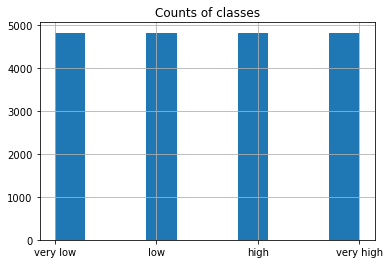

In [10]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset (use only top and bottom quartile data)

In [11]:
cat_lbl = ["very low", "very high"]
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

5793 1931 1932


# Build the model

In [12]:
def create_img_model():
    
    inp = Input(shape=(120, 90, 3))
    
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    base_model.trainable = False
    x = base_model.output
    
    x = AveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(len(cat_lbl), activation="sigmoid")(x)
    
    model = Model(base_model.input, out)
    
    return model

In [13]:
pt_model = "distilbert-base-uncased"

In [14]:
def create_nlp_model():
    config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
    config.output_hidden_states=False
    transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

    in_ids = Input(shape=(100,), name="input_token", dtype="int32")
    in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

    emb = transformer_model(in_ids, attention_mask=in_masks)[0]
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
    x = GlobalMaxPool1D()(x)
    x = Flatten()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[in_ids, in_masks], outputs=x)
        
    return model

In [125]:
def create_model():
    # Load image model with weights and remove last layer
    m_name = "densenet_2_classes_bce_test4"
    img_model = create_img_model()
    img_model.load_weights("../img models/{a}/{a}".format(a=m_name))
    img_model.trainable=False
    
    # Load nlp model with weights and remove last layer
    m_name = "distilbert_2_classes_v2"
    nlp_model = create_nlp_model()
    nlp_model.load_weights("../nlp models/{a}/{a}".format(a=m_name))
    nlp_model.trainable=False
    
    m1 = img_model.layers[-4].output
    m1 = Dense(50, activation="relu")(m1)
    m2 = nlp_model.layers[-3].output
    x = Concatenate()([m1, m2])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation="softmax")(x)
    model = Model(inputs=[img_model.input, nlp_model.input[0], nlp_model.input[1]], outputs=x)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0005),
                  metrics=["accuracy"])
    
    return model    

In [126]:
model = create_model()
# model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


# Text preprocessing and tokenization

In [72]:
def preprocessing_sentence(txt: str, remove_stopwords: bool=False) -> str:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(txt, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(txt)
        txt = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            txt = " ".join([w for w in txt.split() if w not in stw])
        
        return txt
    
    txt = cleanse_row(txt, field, stw, remove_stopwords)
    return txt

In [73]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [75]:
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [76]:
def tokenize(sentence, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    
    inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                   return_token_type_ids=True)
    input_ids.append(inputs["input_ids"])
    input_masks.append(inputs["attention_mask"])
    input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

# Prepare DataGenerators

In [77]:
class TkDataGenerator(Sequence):
    def __init__(self, df, img_col, txt_col, y_col, img_dir, img_pp_func, txt_pp_func, tok_func, tokenizer, lb, batch_size=32, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.img_pp_func = img_pp_func
        self.txt_pp_func = txt_pp_func
        self.tok_func = tok_func
        self.tokenizer = tokenizer
        self.img_col = img_col
        self.txt_col = txt_col
        self.y_col = y_col
        self.img_dir = img_dir
        self.lb = lb
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        x1, x2, x3, y = self.__get_data(batch)
        return [x1, x2, x3], y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_data(self, batch):
        x1 = np.empty((self.batch_size, *(120, 90, 3)))
        x2 = np.empty((self.batch_size, 100))
        x3 = np.empty((self.batch_size, 100))        
        y = np.empty((self.batch_size, 2), dtype="int32")
        
        for i, id in enumerate(batch):
            img = np.transpose(np.asarray(Image.open(os.path.join(img_dir, "{}.jpg".format(self.df.iloc[i, self.df.columns.get_loc(self.img_col)])))), (1, 0, 2))
            pp = self.txt_pp_func(self.df.iloc[i, self.df.columns.get_loc(self.txt_col)])
            t1, t2, t3 = self.tok_func(pp, self.tokenizer)
            
            x1[i] = img
            x2[i] = t1
            x3[i] = t2
            y[i] = lb.transform([self.df.iloc[i, self.df.columns.get_loc(self.y_col)]])
            
        return x1, x2, x3, y

In [78]:
def train_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def val_generator(X, y, img_dir, lb, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=batch_size, 
                              shuffle=True)
    return datagen

def test_generator(X, y, img_dir, lb):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = TkDataGenerator(df=combo, 
                              img_col="id_video", 
                              txt_col="title",
                              y_col="qtl",
                              img_dir=img_dir, 
                              img_pp_func=preprocess_input, 
                              txt_pp_func=preprocessing_sentence, 
                              tok_func=tokenize,
                              tokenizer=tok, 
                              lb=lb,
                              batch_size=1, 
                              shuffle=False)
    return datagen

# Train the model

In [127]:
img_dir = "../images"
batch_size = 64

lb = LabelBinarizer()
lb.fit(y_train)

train_gen = train_generator(x_train, y_train, img_dir, lb, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, lb, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Epoch 1/200
90/90 [==============================] - 47s 385ms/step - loss: 0.6805 - accuracy: 0.4894 - val_loss: 0.4268 - val_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 0.42677, saving model to ../combo models/combo model v1/combo model v1
Epoch 2/200
90/90 [==============================] - 31s 347ms/step - loss: 0.4266 - accuracy: 0.4299 - val_loss: 0.3793 - val_accuracy: 0.3125

Epoch 00002: val_loss improved from 0.42677 to 0.37930, saving model to ../combo models/combo model v1/combo model v1
Epoch 3/200
90/90 [==============================] - 31s 346ms/step - loss: 0.3529 - accuracy: 0.4370 - val_loss: 0.3874 - val_accuracy: 0.3594

Epoch 00003: val_loss did not improve from 0.37930
Epoch 4/200
90/90 [==============================] - 31s 347ms/step - loss: 0.3259 - accuracy: 0.4352 - val_loss: 0.4009 - val_accuracy: 0.4219

Epoch 00004: val_loss did not improve from 0.37930
Epoch 5/200
90/90 [==============================] - 31s 346ms/step - loss: 0.2959 - a

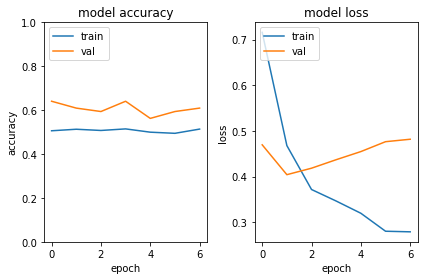

In [119]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Sample images per category

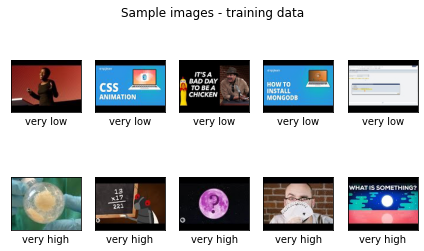

In [26]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=15))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - training data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [27]:
# model = load_model(os.path.join(p_dir, "{}".format(m_name)))
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

In [28]:
def test_generator(X, y, img_dir):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                                )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=False,
                                      batch_size=1                                      
                                     )
    return gen

## Validation dataset (in_sample)

In [29]:
img_dir = "../images"

x_val = pd.read_pickle(os.path.join(p_dir, "x_val.pkl"))
y_val = pd.read_pickle(os.path.join(p_dir, "y_val.pkl"))
val_gen = test_generator(x_val, y_val, img_dir)
y_val_prob = model.predict(val_gen, steps=y_val.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
cls_lbl = dict([(v, k) for k, v in val_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

Found 1931 validated image filenames belonging to 2 classes.


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:202 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_2 expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>]


In [ ]:
cmtx = confusion_matrix(y_val, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_val.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - validation set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_val.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_val, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_val, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_val, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="weighted")))

print(classification_report(y_val, y_pred, target_names=cat_lbl))

## Test dataset (out-of_sample)

In [ ]:
img_dir = "../images"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir)
y_pred_prob = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred_prob, axis=1)
cls_lbl = dict([(v, k) for k, v in test_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

In [ ]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

In [ ]:
s = combo.loc[combo["id_video"].isin(x_val["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=118))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - test data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images_val.jpg"))

# ROC Curve

## Validation dataset (in sample)

In [ ]:
lb = LabelBinarizer()
y_val_no = lb.fit_transform(y_val)
y_pred_no = y_val_prob[:, 1]
fpr, tpr, thr = roc_curve(y_val_no, y_pred_no)

In [ ]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_val_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - validation dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_val.jpg"))
plt.show()

## Test dataset (out-of-sample)

In [ ]:
lb = LabelBinarizer()
y_test_no = lb.fit_transform(y_test)
y_pred_no = y_pred_prob[:,  1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

In [ ]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test set (out-of-sample)")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

In [ ]:
m0 = y_test_no[:, 0] == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_pred_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl, loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

## Including middle classes

In [ ]:
cat_lbl2 = ["very low", "low", "high", "very high"]
combo2 = combo.copy()
combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [ ]:
combo2 = combo2.loc[combo2.qtl.isin(["low", "high"]), :]
combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

In [ ]:
test_gen2 = test_generator(x_test2, y_test2, img_dir)
y_pred_prob2 = model.predict(test_gen2, steps=y_test2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
cls_lbl = dict([(v, k) for k, v in test_gen.class_indices.items()])
y_pred2 = pd.Series([cls_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)

In [ ]:
m0 = y_test_no[:, 0] == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_pred_prob[m1, 1]

m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 0]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 0]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="yellow", alpha=0.3, label="", bins=20)
plt.title("Histogram incl. middle classes")
plt.legend(cat_lbl + ["low", "high"], loc="upper center")
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

# Grad-CAM class activation visualization

In [ ]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

In [ ]:
def cam_image(img_dir, id_video, last_cl, alpha=0.4, pred_class:str="low"):
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img_array = get_img_array(img_path, size=(120, 90))
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    pred_idx = cat_lbl.index(pred_class)
    heatmap = make_gradcam_heatmap(img_array, model, last_cl, pred_idx)
    img = create_gradcam(img_path, heatmap, os.path.join(p_dir, "cam_{}.jpg".format(row["id_video"])), alpha)
    return img

In [ ]:
p = re.compile("conv\d+_block\d+_concat")
p2 = re.compile("conv(\d+)_block(\d+)_concat")
conv_layers = dict()
for layer in model.layers:
    if p.match(layer.name):
        m = p2.search(layer.name)
        if m:
            conv_layers[m.group(1)] = m.group(2)

In [ ]:
target_names = ["conv{}_block{}_concat".format(k, v) for k, v in conv_layers.items()]
for layer in model.layers:
    if layer.name in target_names:        
        alpha = 0.8

        fig, axs = plt.subplots(len(cat_lbl), 5)
        i = 0
        for idx, row in s.iterrows():
            img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
            img = cam_image(img_dir, row["id_video"], layer.name, alpha, row["qtl"])
            axs[i // 5, i % 5].imshow(img)
            axs[i // 5, i % 5].xaxis.set_ticklabels([])
            axs[i // 5, i % 5].xaxis.set_ticks([])
            axs[i // 5, i % 5].set_xlabel(row["qtl"])
            axs[i // 5, i % 5].yaxis.set_ticklabels([])
            axs[i // 5, i % 5].yaxis.set_ticks([])
            i += 1
        plt.suptitle("Layer: {}".format(layer.name))
        plt.tight_layout()        
        plt.show()
        fig.savefig(os.path.join(p_dir, "cam_sample_{}.jpg".format(layer.name)))

# 20 sample images for survey

In [ ]:
survey = combo.loc[combo["id_video"].isin(x_val["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(10, random_state=57))
survey = survey.sample(frac=1)

print(survey.shape)

s_dir = os.path.join("../img models", m_name, "survey images")
create_dir(s_dir)
clear_dir(s_dir)

for idx, row in survey.iterrows():
    copyfile(os.path.join(img_dir, "{}.jpg".format(row["id_video"])), os.path.join(s_dir, "{}_{}.jpg".format(row["id_video"], row["qtl"])))

# Save test set pre

In [ ]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))